# Multi-armed Bandits(MABs)

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        assert narms > 0,'Number of arms cannot be zero'
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.times_arm_played = np.zeros(narms,dtype=int)
        self.Qvalues = np.full(narms,Q0)
        
    def play(self, tround, context=None):
        """"Choosing a random number uniformly(between 0 and 1) and checking if that value is greater than epsilon,then we              exploit the arm with max. Qvalue, else we randomly pick up an arm(possibly explore)"""
        if np.random.rand(1) > self.epsilon:
            
            #Finding the maximum value, not using argmax since if there are duplicate values, it would just return the first one.
            arm = np.where(self.Qvalues == np.amax(self.Qvalues))  
            
            #Tie-breaking
            if len(arm[0]) > 1:
                return np.random.choice(np.asarray(arm[0])) + 1
            else:
                return int(arm[0]) + 1
        else:
            arm = np.random.randint(1, self.narms + 1)
        return arm
            
    def update(self, arm, reward, context=None):
        #Updating the times the arm is played and the Qvalue
        if self.times_arm_played[arm-1] > 0:
            self.times_arm_played[arm-1] += 1
            self.Qvalues[arm-1] = ((self.Qvalues[arm-1] * (self.times_arm_played[arm-1] - 1)) + reward)/self.times_arm_played[arm-1]
        else:
            self.times_arm_played[arm-1] += 1
            self.Qvalues[arm-1] = reward/self.times_arm_played[arm-1]
            
            
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        assert narms>0,'Number of arms cannot be zero'
        self.narms = narms
        assert rho>0,'Rho cannot be zero or less'
        self.rho = rho
        self.Q0 = Q0
        self.times_arm_played = np.zeros(narms,dtype=int)
        self.Qvalues = np.full(narms,Q0)
        self.UCBQvals = np.full(narms,Q0)
        
    def play(self, tround, context=None):
        #For every arm, finding the UCB-Qvalues using explore boost
        for arm in range(1,self.narms+1):
            if self.times_arm_played[arm-1] > 0:
                self.UCBQvals[arm-1] = self.Qvalues[arm-1] + np.sqrt((self.rho*np.log(tround))/self.times_arm_played[arm-1])
        arm = np.where(self.UCBQvals == np.amax(self.UCBQvals))
        
        #Tie breaking
        if len(arm[0]) > 1:
            return np.random.choice(np.asarray(arm[0])) + 1
        else:
            return int(arm[0]) + 1
        
        
    def update(self, arm, reward, context=None):
        #Updating number of times arm played and Qvalue
        if self.times_arm_played[arm-1] > 0:
            self.times_arm_played[arm-1] += 1
            self.Qvalues[arm-1] = ((self.Qvalues[arm-1] * (self.times_arm_played[arm-1] - 1)) + reward)/self.times_arm_played[arm-1]
        else:
            self.times_arm_played[arm-1] += 1
            self.Qvalues[arm-1] = reward/self.times_arm_played[arm-1]
        
    

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        assert narms>0,'Number of arms cannot be zero'
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.successes = np.zeros(narms,dtype=int)
        self.failures = np.zeros(narms,dtype=int)
        self.probab = np.zeros(narms)
    
    def play(self, tround, context=None):
        #Calculating the probabilities related to each arm using beta distribution
        for arm in range(1,self.narms+1):
            self.probab[arm-1] = np.random.beta(self.successes[arm-1] + self.alpha0, self.failures[arm-1] + self.beta0)
        arm = np.where(self.probab == np.amax(self.probab))
        
        #Tie breaking
        if len(arm[0]) > 1:
            return np.random.choice(np.asarray(arm[0])) + 1
        else:
            return int(arm[0]) + 1 
            
        
    def update(self, arm, reward, context=None):
        #Updating success count if reward=1, else failure is increased by 1
        if reward == 1.0:
            self.successes[arm-1] = self.successes[arm-1] + 1
        else:
            self.failures[arm-1] = self.failures[arm-1] + 1
            

## 3. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """

    #Checking if arm selected by the algorithms and the ones logged are the same for an event till specified nrounds
    #Instead of taking a separate history variable, used a list chosen_rewards.
    
    chosen_rewards = []
    
    assert mab!=None,'Specify an algorithm to be checked'

    for i in range(0,len(arms)):
        if len(chosen_rewards) == nrounds:
            break
        else:
            if mab.play(len(chosen_rewards) + 1, contexts[i]) == arms[i]:
                mab.update(arms[i],rewards[i],contexts[i])

                chosen_rewards.append(rewards[i])
               
    return np.array(chosen_rewards)


In [7]:
#Extracting data from the given dataset
file = open('dataset.txt','r')
nevents = 10000
arms = []
rewards = []
contexts = []

for line in file:
    fields = line.split(' ')
    arms.append(int(fields[0]))
    rewards.append(float(fields[1]))
    contexts.append(np.asarray(fields[2:102],dtype=float))
    
arms = np.array(arms)
rewards = np.array(rewards)
contexts = np.array(contexts)



In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print("EpsGreedy average reward ", np.mean(results_EpsGreedy))

EpsGreedy average reward  0.2575


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1625


In [10]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.23625


## 4. Contextual Bandits - LinUCB

In [11]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        assert narms>0,'Number of arms cannot be less than or equal to zero'
        
        #Names of variables as given in the paper
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A = np.array([np.identity(ndims) for i in range(0,narms)])
        self.b = np.array([np.zeros((ndims,1)) for i in range(0,narms)])
        self.thetaHat = np.array([np.zeros((ndims,1)) for i in range(0,narms)])
        self.probab = np.zeros(narms)
        
    def play(self, tround, context):
        
        context = np.reshape(context,(10,10,1))
        
        for arm in range(0,self.narms):
            Ainv = np.linalg.inv(self.A[arm])
            self.thetaHat[arm] = np.dot(Ainv,self.b[arm])
            self.probab[arm] = np.dot((np.transpose(self.thetaHat[arm])),context[arm]) + self.alpha * np.sqrt(np.dot(np.transpose(context[arm]),np.dot(Ainv,context[arm])))
        
        chosenarm = np.where(self.probab == np.amax(self.probab))
        if len(chosenarm[0]) > 1:
            return np.random.choice(np.asarray(chosenarm[0])) + 1
        else:
            return int(chosenarm[0]) + 1 
          
    
    def update(self, arm, reward, context):
        context = np.reshape(context,(10,10,1))
        
        self.A[arm-1] += np.dot(context[arm-1],np.transpose(context[arm-1]))
        self.b[arm-1] += reward * context[arm-1]
        
    

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [13]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        #Names of variables as given in paper
        self.narms = narms
        self.ndims = ndims
        self.v = v
        self.B = np.identity(ndims) 
        self.muHat = np.zeros(ndims)
        self.f = np.zeros(ndims) 
        self.probab = np.zeros(narms)
        
    def play(self, tround, context):
        context = np.reshape(context,(10,10))
        for arm in range(0,self.narms):
            Binv = np.linalg.inv(self.B)
            cov = (self.v * self.v)* Binv
            self.muTilda = np.random.multivariate_normal((self.muHat),cov)
            self.probab[arm] = np.dot(np.transpose(context[arm]),self.muTilda)
            
        chosenarm = np.where(self.probab == np.amax(self.probab))
        if len(chosenarm[0]) > 1:
            return np.random.choice(np.asarray(chosenarm[0])) + 1
        else:
            return int(chosenarm[0]) + 1
            

    def update(self, arm, reward, context):
        context = np.reshape(context,(10,10))
        self.B += np.dot(context[arm-1],np.transpose(context[arm-1]))
        self.f += reward * context[arm-1]
        self.muHat = np.dot(np.linalg.inv(self.B),self.f)

In [14]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.2675


## 6. Evaluation
### 6.A.

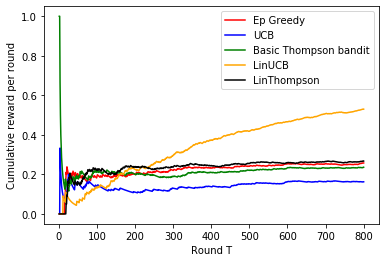

In [15]:
#Function to calculate cumulative rewards
def calculateCR(results):
    cumulative_rewards = []
    cumulative_rewards.append(results[0])
    for r in range(1,len(results)):
        cumulative_rewards.append((cumulative_rewards[r-1]*(r) + results[r])/(r+1))
    return cumulative_rewards

x = np.array(list(range(1,801)))
y_egreedy = np.array(np.array(calculateCR(results_EpsGreedy)))
y_ucb = np.array(calculateCR(results_UCB))
y_bt = np.array(calculateCR(results_BetaThompson))
y_linUCB = np.array(calculateCR(results_LinUCB))
y_linThompson = np.array(calculateCR(results_LinThompson))

plt.plot(x,y_egreedy,'red', label='Ep Greedy')
plt.plot(x,y_ucb,'blue',label = 'UCB')
plt.plot(x,y_bt,'green', label = 'Basic Thompson bandit')
plt.plot(x,y_linUCB,'orange', label = 'LinUCB')
plt.plot(x,y_linThompson,'black',label='LinThompson')
plt.xlabel('Round T')
plt.ylabel('Cumulative reward per round')
plt.legend()

### 6.B.

In [16]:
#Hyperparameter optimization for LinUCB and LinThompson Hyperparameter
results_UCB = []
range_UCB = np.linspace(0.0,1.0,20)
for i in range_UCB:
    results_UCB.append(np.mean(offlineEvaluate(LinUCB(10,10,i), arms, rewards, contexts, 800)))

results_LinThompson= []
range_LinThompson = np.linspace(0.0,1.0,20)
for i in range_LinThompson:
    results_LinThompson.append(np.mean(offlineEvaluate(LinThompson(10,10,i), arms, rewards, contexts, 800)))



LinUCB: The max value of mean reward is 0.733750 at alpha 0.052632
LinThompson: The max value of mean reward is 0.350000 at alpha 0.000000


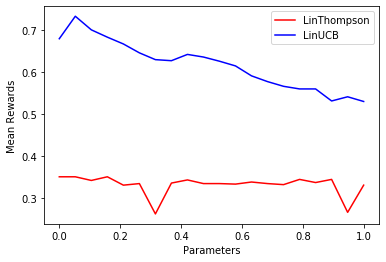

In [17]:
print('LinUCB: The max value of mean reward is %f at alpha %f' %(max(results_UCB),range_UCB[results_UCB.index(max(results_UCB))]))
print('LinThompson: The max value of mean reward is %f at alpha %f' %(max(results_LinThompson),range_LinThompson[results_LinThompson.index(max(results_LinThompson))]))
plt.plot(range_LinThompson,results_LinThompson,'red',label='LinThompson')
plt.plot(range_UCB,results_UCB,'blue',label='LinUCB')
plt.xlabel('Parameters')
plt.ylabel('Mean Rewards')
plt.legend()